In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import dateutil.relativedelta as rd
import matplotlib.pyplot as plt

In [2]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import statsmodels.api as sm
from scipy import stats

In [3]:
# Display all the columns for the dataframes (not-truncated)
pd.set_option("display.max_columns", None)
# Format floats better
pd.options.display.float_format = '{:,.4f}'.format

In [4]:
covid_df = pd.read_csv("Resources/covid_data.csv")
covid_df

,Unnamed: 0,id,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,icu,vent,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,facial_coverings,vaccination_policy,elderly_people_protection,government_response_index,stringency_index,containment_health_index,economic_support_index,administrative_area_level,administrative_area_level_1,administrative_area_level_2,administrative_area_level_3,latitude,longitude,population,iso_alpha_3,iso_alpha_2,iso_numeric,iso_currency,key_local,key_google_mobility,key_apple_mobility,key_jhu_csse,key_nuts,key_gadm
0,26885,0094b645,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Saint Lucia,NaN,NaN,13.9094,-60.9789,"181,889.0000",LCA,LC,662.0000,XCD,NaN,NaN,NaN,LC,NaN,LCA
1,26886,0094b645,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Saint Lucia,NaN,NaN,13.9094,-60.9789,"181,889.0000",LCA,LC,662.0000,XCD,NaN,NaN,NaN,LC,NaN,LCA
2,26887,0094b645,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Saint Lucia,NaN,NaN,13.9094,-60.9789,"181,889.0000",LCA,LC,662.0000,XCD,NaN,NaN,NaN,LC,NaN,LCA
3,26888,0094b645,2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Saint Lucia,NaN,NaN,13.9094,-60.9789,"181,889.0000",LCA,LC,662.0000,XCD,NaN,NaN,NaN,LC,NaN,LCA
4,26889,0094b645,2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Saint Lucia,NaN,NaN,13.9094,-60.9789,"181,889.0000",LCA,LC,662.0000,XCD,NaN,NaN,NaN,LC,NaN,LCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162176,113401,fd169ad6,2022-01-07,"6,767.0000",67.0000,NaN,"90,009.0000","64,648.0000","26,229.0000","25,701.0000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Liechtenstein,NaN,NaN,47.1400,9.5500,"37,910.0000",LIE,LI,438.0000,CHF,NaN,ChIJ_S9HHUQxm0cRibFa3Ta16mA,NaN,LI,NaN,LIE
162177,113402,fd169ad6,2022-01-08,"6,823.0000",67.0000,NaN,"90,204.0000","64,796.0000","26,377.0000","25,702.0000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Liechtenstein,NaN,NaN,47.1400,9.5500,"37,910.0000",LIE,LI,438.0000,CHF,NaN,ChIJ_S9HHUQxm0cRibFa3Ta16mA,NaN,LI,NaN,LIE
162178,113403,fd169ad6,2022-01-09,"6,887.0000",67.0000,"6,163.0000","90,383.0000","64,796.0000","26,377.0000","25,702.0000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Liechtenstein,NaN,NaN,47.1400,9.5500,"37,910.0000",LIE,LI,438.0000,CHF,NaN,ChIJ_S9HHUQxm0cRibFa3Ta16mA,NaN,LI,NaN,LIE
162179,113404,fd169ad6,2022-01-10,"6,915.0000",67.0000,"6,230.0000","90,433.0000","65,310.0000","26,385.0000","25,738.0000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Liechtenstein,NaN,NaN,47.1400,9.5500,"37,910.0000",LIE,LI,438.0000,CHF,NaN,ChIJ_S9HHUQxm0cRibFa3Ta16mA,NaN,LI,NaN,LIE


In [5]:
covid_df = covid_df.groupby(["date"])[[
    "deaths",
    "vaccines",
    "people_vaccinated",
    "people_fully_vaccinated",
    "school_closing",
    "workplace_closing",
]].sum()
covid_df.index = pd.to_datetime(covid_df.index)
covid_df

,deaths,vaccines,people_vaccinated,people_fully_vaccinated,school_closing,workplace_closing
date,,,,,,
2020-01-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2020-01-02,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2020-01-03,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2020-01-04,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2020-01-05,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...
2022-01-07,"5,286,317.0000","7,259,162,583.0000","3,480,744,034.0000","3,013,097,777.0000",43.0000,61.0000
2022-01-08,"5,290,633.0000","7,473,747,216.0000","2,320,880,247.0000","1,866,975,858.0000",39.0000,53.0000
2022-01-09,"5,293,761.0000","7,769,900,363.0000","2,410,029,675.0000","2,010,571,139.0000",35.0000,45.0000


In [6]:
feature_columns = [
    "vaccines",
    "people_vaccinated",
    "people_fully_vaccinated",
#     "school_closing",
#     "workplace_closing",
]

# Select the target feature
target_feature = "deaths"

In [7]:
X = covid_df[feature_columns]
y = covid_df[[target_feature]].values.ravel()

In [8]:
from sklearn.model_selection import TimeSeriesSplit

def train_time_serise(X,y,testing_size):
    model = LinearRegression()
    summary = {
        "rmse":[],
        "train_start":[],
        "train_end":[],
        "test_start":[],
        "test_end":[],
    }
    tscv = TimeSeriesSplit(n_splits=int(X.shape[0]/testing_size) - 1, test_size=testing_size)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        y_hat = model.predict(X_test)
        summary["rmse"].append(np.sqrt(mse(y_hat,y_test)))
        summary["train_start"].append(str(X_train.index.min().date()))
        summary["train_end"].append(str(X_train.index.max().date()))
        summary["test_start"].append(str(X_test.index.min().date()))
        summary["test_end"].append(str(X_test.index.max().date()))
    return model, pd.DataFrame(summary)

In [9]:
split = 30
model, time_serise_summary_df = train_time_serise(X,y,split)
time_serise_summary_df

,rmse,train_start,train_end,test_start,test_end
0,"5,884.3397",2020-01-01,2020-02-21,2020-02-22,2020-03-22
1,"93,742.4525",2020-01-01,2020-03-22,2020-03-23,2020-04-21
2,"221,319.3924",2020-01-01,2020-04-21,2020-04-22,2020-05-21
3,"302,021.5668",2020-01-01,2020-05-21,2020-05-22,2020-06-20
4,"386,581.1030",2020-01-01,2020-06-20,2020-06-21,2020-07-20
5,"497,823.7324",2020-01-01,2020-07-20,2020-07-21,2020-08-19
6,"5,089,811.6149",2020-01-01,2020-08-19,2020-08-20,2020-09-18
7,"3,498,355.5958",2020-01-01,2020-09-18,2020-09-19,2020-10-18
8,"2,991,732.5531",2020-01-01,2020-10-18,2020-10-19,2020-11-17
9,"115,998,389,690.1869",2020-01-01,2020-11-17,2020-11-18,2020-12-17


In [10]:
def linear_regression_summary(model, X, y):
    # https://stackoverflow.com/a/42677750
    coefficients = np.append(model.intercept_, model.coef_)
    predictions = model.predict(X)

    constant_name = "Constant (y-intercept)"
    X_appended = X.copy()
    X_appended[constant_name] = 1
    X_appended = X_appended.reindex(columns=[constant_name] + list(X.columns))
    
    MSE = (sum((y-predictions)**2))/(len(X_appended)-len(X_appended.columns))
    std_err = np.sqrt(MSE * (np.linalg.inv(np.dot(X_appended.T,X_appended)).diagonal()))
    t_values = coefficients / std_err
    p_values = [2*(1-stats.t.cdf(np.abs(i),(len(X_appended)-len(X_appended.iloc[0])))) for i in t_values]

    summary_df = pd.DataFrame(index = X_appended.columns)
    summary_df.index.name = "Feature"
    summary_df["Coefficients"] = coefficients
    summary_df["Standard Errors"] = std_err
    summary_df["t"] = t_values
    summary_df["P>|t|"] = p_values
    
    return summary_df

In [11]:
summary_df = linear_regression_summary(model,X,y)
summary_df.sort_values(by=["P>|t|"],ascending=False)

,Coefficients,Standard Errors,t,P>|t|
Feature,,,,
vaccines,-0.0002,0.0001,-1.9868,0.0473
Constant (y-intercept),"1,007,053.7607","35,174.9993",28.6298,0.0000
people_vaccinated,0.0034,0.0002,15.0901,0.0000
people_fully_vaccinated,-0.0015,0.0002,-9.7504,0.0000


In [12]:
def combine_feature_with_coefficients(df,summary_df):
    cols = list(set(df.columns) & set(summary_df.index))
    data_df = df[cols].copy(deep=True)
    coeff_df = summary_df.loc[cols,"Coefficients"]
    for col in cols:
        data_df[col] = data_df[col] * coeff_df[col]
    return data_df

<AxesSubplot:xlabel='date'>

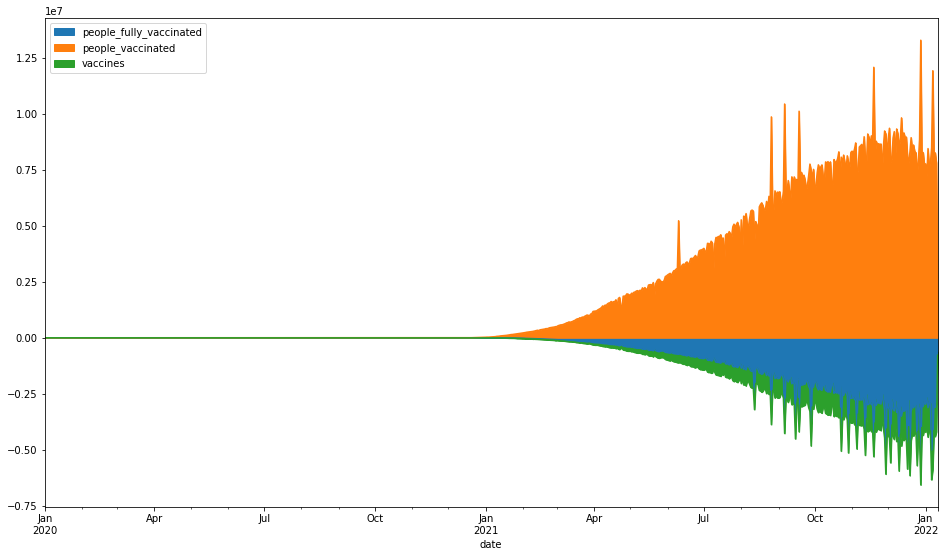

In [13]:
data_df = combine_feature_with_coefficients(covid_df,summary_df)
data_df.plot(kind="area",stacked=True,figsize=(16,9))

<AxesSubplot:xlabel='date'>

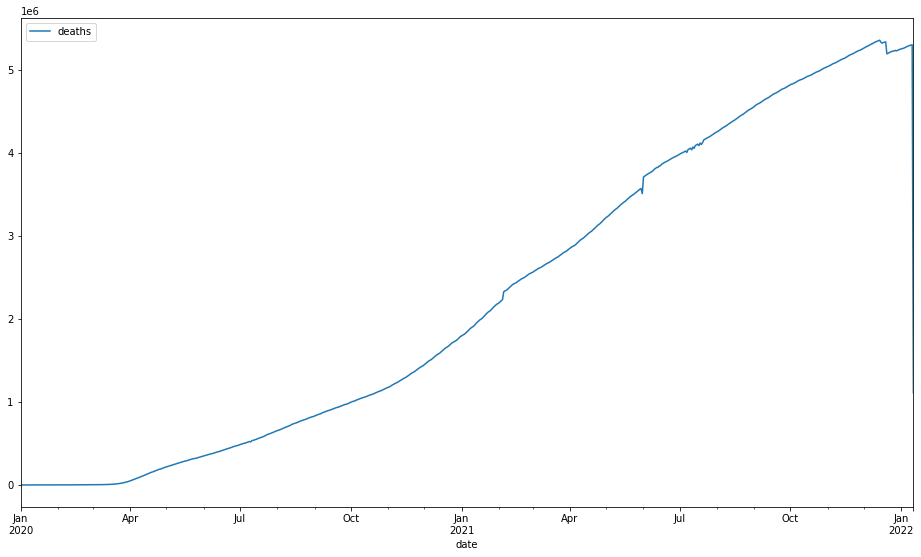

In [14]:
covid_df[[target_feature]].plot(figsize=(16,9))